##Finetuning Of ResNet101


In [ ]:
import tensorflow as tf
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.applications import ResNet101
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

# Parameters
batch_size = 32
img_height = 224
img_width = 224
num_classes = 14
epochs = 50
data_dir = '/content/drive/MyDrive/pc_parts'

# Load the dataset
train_dataset = image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset="training",
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size)

validation_dataset = image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset="validation",
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size)

# Normalize the images to [0, 1]
normalization_layer = tf.keras.layers.Rescaling(1./255)

normalized_train_ds = train_dataset.map(lambda x, y: (normalization_layer(x), y))
normalized_val_ds = validation_dataset.map(lambda x, y: (normalization_layer(x), y))

# Load the pre-trained ResNet101 model
base_model = ResNet101(weights='imagenet', include_top=False, input_shape=(img_height, img_width, 3))

# Freeze the base model
base_model.trainable = False

# Add custom layers on top of the base model
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
predictions = Dense(num_classes, activation='softmax')(x)

# Create the full model
model = Model(inputs=base_model.input, outputs=predictions)

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.001),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# Train the model
model.fit(
    normalized_train_ds,
    validation_data=normalized_val_ds,
    epochs=epochs
)

# Unfreeze some layers for fine-tuning
base_model.trainable = True

# Recompile the model with a lower learning rate
model.compile(optimizer=Adam(learning_rate=0.0001),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# Fine-tune the model
model.fit(
    normalized_train_ds,
    validation_data=normalized_val_ds,
    epochs=epochs
)


Found 790 files belonging to 4 classes.
Using 632 files for training.
Found 790 files belonging to 4 classes.
Using 158 files for validation.
171446536/171446536 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step
Epoch 1/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 165s 7s/step - accuracy: 0.3016 - loss: 1.6559 - val_accuracy: 0.5190 - val_loss: 1.1290
Epoch 2/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 4s 187ms/step - accuracy: 0.4387 - loss: 1.2157 - val_accuracy: 0.4810 - val_loss: 1.1269
Epoch 3/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 4s 181ms/step - accuracy: 0.5111 - loss: 1.1585 - val_accuracy: 0.4177 - val_loss: 1.1966
Epoch 4/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 4s 210ms/step - accuracy: 0.4981 - loss: 1.1508 - val_accuracy: 0.5063 - val_loss: 1.1693
Epoch 5/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 5s 183ms/step - accuracy: 0.4625 - loss: 1.2612 - val_accuracy: 0.5000 - val_loss: 1.1241
Epoch 6/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 5s 184ms/step - accuracy: 0.5003 - loss: 1.1052 - val_accuracy: 0.5506 - val_loss: 1.0587
Epoch 7/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 

##Vision Transformer architecture from Scratch

In [ ]:
import os
import keras
from keras import layers
from keras import ops

import numpy as np
import matplotlib.pyplot as plt

In [ ]:
import tensorflow as tf
import numpy as np

num_classes = 14
input_shape = (224, 224, 3)
batch_size = 32

# Load the dataset with training and validation subsets
train_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "/content/drive/MyDrive/pc_parts",
    validation_split=0.2,
    subset="training",
    seed=123,
    image_size=input_shape[:2],
    batch_size=batch_size
)

validation_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "/content/drive/MyDrive/pc_parts",
    validation_split=0.2,
    subset="validation",
    seed=123,
    image_size=input_shape[:2],
    batch_size=batch_size
)

# Function to extract features and labels from a dataset
def extract_features_and_labels(dataset):
    features = []
    labels = []
    for images, lbls in dataset:
        features.append(images.numpy())
        labels.append(lbls.numpy())
    return np.concatenate(features), np.concatenate(labels)

# Extract features and labels from the training dataset
x_train, y_train = extract_features_and_labels(train_dataset)

# Extract features and labels from the validation dataset
x_test, y_test = extract_features_and_labels(validation_dataset)

# Check shapes
print(f"x_train shape: {x_train.shape}, y_train shape: {y_train.shape}")
print(f"x_test shape: {x_test.shape}, y_test shape: {y_test.shape}")


Found 3279 files belonging to 14 classes.
Using 2624 files for training.
Found 3279 files belonging to 14 classes.
Using 655 files for validation.
x_train shape: (2624, 224, 224, 3), y_train shape: (2624,)
x_test shape: (655, 224, 224, 3), y_test shape: (655,)


In [ ]:
learning_rate = 0.001
weight_decay = 0.0001
batch_size = 256
num_epochs = 100  # For real training, use num_epochs=100. 10 is a test value
image_size = 72  # We'll resize input images to this size
patch_size = 6  # Size of the patches to be extract from the input images
num_patches = (image_size // patch_size) ** 2
projection_dim = 64
num_heads = 4
transformer_units = [
    projection_dim * 2,
    projection_dim,
]  # Size of the transformer layers
transformer_layers = 8
mlp_head_units = [
    2048,
    1024,
]

In [ ]:
data_augmentation = keras.Sequential(
    [
        layers.Normalization(),
        layers.Resizing(image_size, image_size),
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(factor=0.02),
        layers.RandomZoom(height_factor=0.2, width_factor=0.2),
    ],
    name="data_augmentation",
)
# Compute the mean and the variance of the training data for normalization.
data_augmentation.layers[0].adapt(x_train)

In [ ]:
def mlp(x, hidden_units, dropout_rate):
    for units in hidden_units:
        x = layers.Dense(units, activation=keras.activations.gelu)(x)
        x = layers.Dropout(dropout_rate)(x)
    return x

In [ ]:
class Patches(layers.Layer):
    def __init__(self, patch_size):
        super().__init__()
        self.patch_size = patch_size

    def call(self, images):
        input_shape = ops.shape(images)
        batch_size = input_shape[0]
        height = input_shape[1]
        width = input_shape[2]
        channels = input_shape[3]
        num_patches_h = height // self.patch_size
        num_patches_w = width // self.patch_size
        patches = keras.ops.image.extract_patches(images, size=self.patch_size)
        patches = ops.reshape(
            patches,
            (
                batch_size,
                num_patches_h * num_patches_w,
                self.patch_size * self.patch_size * channels,
            ),
        )
        return patches

    def get_config(self):
        config = super().get_config()
        config.update({"patch_size": self.patch_size})
        return config


Image size: 72 X 72
Patch size: 6 X 6
Patches per image: 144
Elements per patch: 108


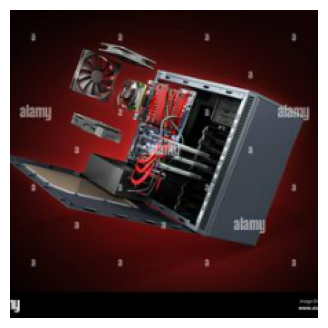

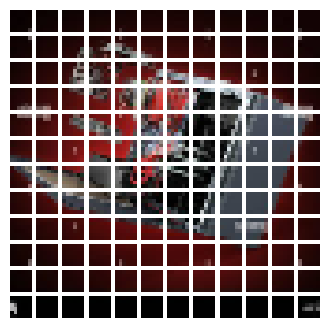

In [ ]:
plt.figure(figsize=(4, 4))
image = x_train[np.random.choice(range(x_train.shape[0]))]
plt.imshow(image.astype("uint8"))
plt.axis("off")

resized_image = ops.image.resize(
    ops.convert_to_tensor([image]), size=(image_size, image_size)
)
patches = Patches(patch_size)(resized_image)
print(f"Image size: {image_size} X {image_size}")
print(f"Patch size: {patch_size} X {patch_size}")
print(f"Patches per image: {patches.shape[1]}")
print(f"Elements per patch: {patches.shape[-1]}")

n = int(np.sqrt(patches.shape[1]))
plt.figure(figsize=(4, 4))
for i, patch in enumerate(patches[0]):
    ax = plt.subplot(n, n, i + 1)
    patch_img = ops.reshape(patch, (patch_size, patch_size, 3))
    plt.imshow(ops.convert_to_numpy(patch_img).astype("uint8"))
    plt.axis("off")

In [ ]:
class PatchEncoder(layers.Layer):
    def __init__(self, num_patches, projection_dim):
        super().__init__()
        self.num_patches = num_patches
        self.projection = layers.Dense(units=projection_dim)
        self.position_embedding = layers.Embedding(
            input_dim=num_patches, output_dim=projection_dim
        )

    def call(self, patch):
        positions = ops.expand_dims(
            ops.arange(start=0, stop=self.num_patches, step=1), axis=0
        )
        projected_patches = self.projection(patch)
        encoded = projected_patches + self.position_embedding(positions)
        return encoded

    def get_config(self):
        config = super().get_config()
        config.update({"num_patches": self.num_patches})
        return config

In [ ]:
def create_vit_classifier():
    inputs = keras.Input(shape=input_shape)
    # Augment data.
    augmented = data_augmentation(inputs)
    # Create patches.
    patches = Patches(patch_size)(augmented)
    # Encode patches.
    encoded_patches = PatchEncoder(num_patches, projection_dim)(patches)

    # Create multiple layers of the Transformer block.
    for _ in range(transformer_layers):
        # Layer normalization 1.
        x1 = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
        # Create a multi-head attention layer.
        attention_output = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=projection_dim, dropout=0.1
        )(x1, x1)
        # Skip connection 1.
        x2 = layers.Add()([attention_output, encoded_patches])
        # Layer normalization 2.
        x3 = layers.LayerNormalization(epsilon=1e-6)(x2)
        # MLP.
        x3 = mlp(x3, hidden_units=transformer_units, dropout_rate=0.1)
        # Skip connection 2.
        encoded_patches = layers.Add()([x3, x2])

    # Create a [batch_size, projection_dim] tensor.
    representation = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
    representation = layers.Flatten()(representation)
    representation = layers.Dropout(0.5)(representation)
    # Add MLP.
    features = mlp(representation, hidden_units=mlp_head_units, dropout_rate=0.5)
    # Classify outputs.
    logits = layers.Dense(num_classes)(features)
    # Create the Keras model.
    model = keras.Model(inputs=inputs, outputs=logits)
    return model

Epoch 1/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 41s 2s/step - accuracy: 0.0745 - loss: 6.6993 - top-5-accuracy: 0.3823 - val_accuracy: 0.1065 - val_loss: 2.6850 - val_top-5-accuracy: 0.4373
Epoch 2/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 15s 2s/step - accuracy: 0.0902 - loss: 3.0721 - top-5-accuracy: 0.4062 - val_accuracy: 0.1255 - val_loss: 2.5735 - val_top-5-accuracy: 0.4449
Epoch 3/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 21s 2s/step - accuracy: 0.0855 - loss: 2.7931 - top-5-accuracy: 0.4178 - val_accuracy: 0.1559 - val_loss: 2.5457 - val_top-5-accuracy: 0.5361
Epoch 4/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 15s 2s/step - accuracy: 0.1013 - loss: 2.6794 - top-5-accuracy: 0.4513 - val_accuracy: 0.1787 - val_loss: 2.5266 - val_top-5-accuracy: 0.5665
Epoch 5/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 5s 472ms/step - accuracy: 0.1181 - loss: 2.6180 - top-5-accuracy: 0.4842 - val_accuracy: 0.1597 - val_loss: 2.5089 - val_top-5-accuracy: 0.5627
Epoch 6/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 19s 2s/step - accuracy: 0.1288 - loss: 2.6028 - top-5-

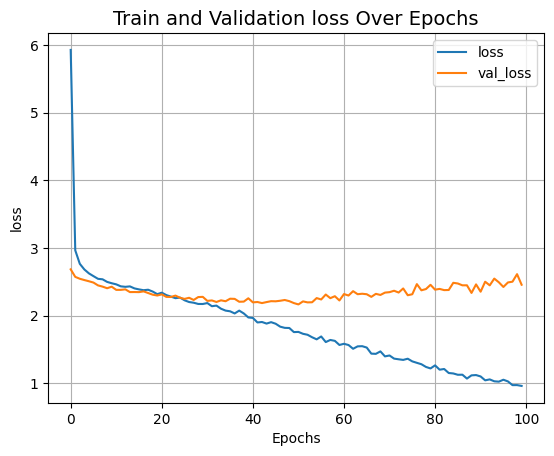

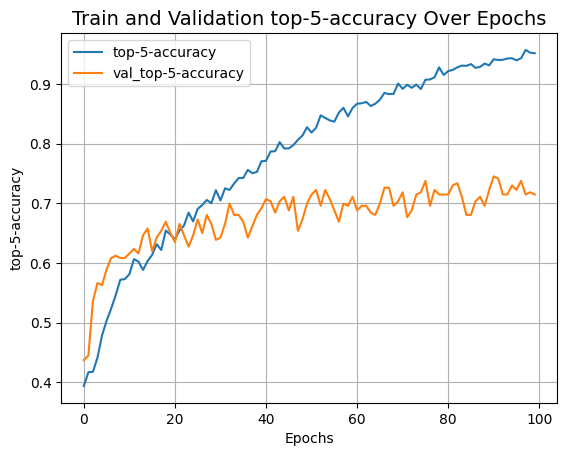

In [ ]:
def run_experiment(model):
    optimizer = keras.optimizers.AdamW(
        learning_rate=learning_rate, weight_decay=weight_decay
    )

    model.compile(
        optimizer=optimizer,
        loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
        metrics=[
            keras.metrics.SparseCategoricalAccuracy(name="accuracy"),
            keras.metrics.SparseTopKCategoricalAccuracy(5, name="top-5-accuracy"),
        ],
    )

    checkpoint_filepath = "/tmp/checkpoint.weights.h5"
    checkpoint_callback = keras.callbacks.ModelCheckpoint(
        checkpoint_filepath,
        monitor="val_accuracy",
        save_best_only=True,
        save_weights_only=True,
    )

    history = model.fit(
        x=x_train,
        y=y_train,
        batch_size=batch_size,
        epochs=num_epochs,
        validation_split=0.1,
        callbacks=[checkpoint_callback],
    )

    model.load_weights(checkpoint_filepath)
    _, accuracy, top_5_accuracy = model.evaluate(x_test, y_test)
    print(f"Test accuracy: {round(accuracy * 100, 2)}%")
    print(f"Test top 5 accuracy: {round(top_5_accuracy * 100, 2)}%")

    return history


vit_classifier = create_vit_classifier()
history = run_experiment(vit_classifier)


def plot_history(item):
    plt.plot(history.history[item], label=item)
    plt.plot(history.history["val_" + item], label="val_" + item)
    plt.xlabel("Epochs")
    plt.ylabel(item)
    plt.title("Train and Validation {} Over Epochs".format(item), fontsize=14)
    plt.legend()
    plt.grid()
    plt.show()


plot_history("loss")
plot_history("top-5-accuracy")

In [ ]:
model.summary()

Model: "functional_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_4             │ (None, 224, 224, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ Conv1 (Conv2D)            │ (None, 112, 112, 32)   │            864 │ input_layer_4[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ bn_Conv1                  │ (None, 112, 112, 32)   │            128 │ Conv1[0][0]            │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ Conv1_relu (ReLU)         │ (None, 112, 112, 32)   │              0 │ bn_Conv1[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_depthwise   │ (None, 112, 112, 32)   │            288 │ Conv1_relu[0][0]       │
│ (DepthwiseConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_depthwise_… │ (None, 112, 112, 32)   │            128 │ expanded_conv_depthwi… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_depthwise_… │ (None, 112, 112, 32)   │              0 │ expanded_conv_depthwi… │
│ (ReLU)                    │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_project     │ (None, 112, 112, 16)   │            512 │ expanded_conv_depthwi… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_project_BN  │ (None, 112, 112, 16)   │             64 │ expanded_conv_project… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_expand (Conv2D)   │ (None, 112, 112, 96)   │          1,536 │ expanded_conv_project… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_expand_BN         │ (None, 112, 112, 96)   │            384 │ block_1_expand[0][0]   │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_expand_relu       │ (None, 112, 112, 96)   │              0 │ block_1_expand_BN[0][… │
│ (ReLU)                    │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_pad               │ (None, 113, 113, 96)   │              0 │ block_1_expand_relu[0… │
│ (ZeroPadding2D)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_depthwise         │ (None, 56, 56, 96)     │            864 │ block_1_pad[0][0]      │
│ (DepthwiseConv2D)         │                        │                │                        │
├──────────────────────

 Total params: 6,034,668 (23.02 MB)

 Trainable params: 1,879,374 (7.17 MB)

 Non-trainable params: 396,544 (1.51 MB)

 Optimizer params: 3,758,750 (14.34 MB)

##FineTuning of MobileNetV2


In [ ]:
import tensorflow as tf
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model

# Load MobileNetV2 with pre-trained ImageNet weights
base_model = MobileNetV2(input_shape=input_shape, include_top=False, weights='imagenet')

# Freeze the base model
base_model.trainable = False


9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [ ]:
# Add a global average pooling layer
x = base_model.output
x = GlobalAveragePooling2D()(x)

# Add a dense layer with the number of classes
x = Dense(num_classes, activation='softmax')(x)

# Create the new model
model = Model(inputs=base_model.input, outputs=x)

# Compile the model
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])


In [ ]:
# Train the model
history = model.fit(
    train_dataset,
    validation_data=validation_dataset,
    epochs=10  # You can adjust the number of epochs
)


Epoch 1/10
82/82 ━━━━━━━━━━━━━━━━━━━━ 12s 141ms/step - accuracy: 0.6754 - loss: 1.1482 - val_accuracy: 0.5237 - val_loss: 1.6149
Epoch 2/10
82/82 ━━━━━━━━━━━━━━━━━━━━ 21s 145ms/step - accuracy: 0.6873 - loss: 1.0775 - val_accuracy: 0.5115 - val_loss: 1.6255
Epoch 3/10
82/82 ━━━━━━━━━━━━━━━━━━━━ 19s 131ms/step - accuracy: 0.6966 - loss: 1.0630 - val_accuracy: 0.5313 - val_loss: 1.5941
Epoch 4/10
82/82 ━━━━━━━━━━━━━━━━━━━━ 22s 146ms/step - accuracy: 0.7210 - loss: 0.9937 - val_accuracy: 0.5221 - val_loss: 1.6122
Epoch 5/10
82/82 ━━━━━━━━━━━━━━━━━━━━ 19s 132ms/step - accuracy: 0.7246 - loss: 0.9558 - val_accuracy: 0.5206 - val_loss: 1.6196
Epoch 6/10
82/82 ━━━━━━━━━━━━━━━━━━━━ 21s 144ms/step - accuracy: 0.7207 - loss: 0.9484 - val_accuracy: 0.5313 - val_loss: 1.6406
Epoch 7/10
82/82 ━━━━━━━━━━━━━━━━━━━━ 20s 136ms/step - accuracy: 0.7591 - loss: 0.9066 - val_accuracy: 0.5237 - val_loss: 1.6219
Epoch 8/10
82/82 ━━━━━━━━━━━━━━━━━━━━ 21s 143ms/step - accuracy: 0.7607 - loss: 0.8618 - val_accu

In [ ]:
# Unfreeze the base model for fine-tuning
base_model.trainable = True

# Optionally, freeze some layers and only fine-tune higher layers
for layer in base_model.layers[:100]:
    layer.trainable = False

# Recompile the model with a lower learning rate for fine-tuning
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# Fine-tune the model
fine_tune_history = model.fit(
    train_dataset,
    validation_data=validation_dataset,
    epochs=10  # Adjust as needed
)


Epoch 1/10
82/82 ━━━━━━━━━━━━━━━━━━━━ 37s 189ms/step - accuracy: 0.2437 - loss: 3.8484 - val_accuracy: 0.4748 - val_loss: 1.8665
Epoch 2/10
82/82 ━━━━━━━━━━━━━━━━━━━━ 28s 139ms/step - accuracy: 0.3954 - loss: 2.2027 - val_accuracy: 0.4779 - val_loss: 1.9398
Epoch 3/10
82/82 ━━━━━━━━━━━━━━━━━━━━ 21s 140ms/step - accuracy: 0.4834 - loss: 1.6659 - val_accuracy: 0.4931 - val_loss: 1.8851
Epoch 4/10
82/82 ━━━━━━━━━━━━━━━━━━━━ 20s 140ms/step - accuracy: 0.5359 - loss: 1.4641 - val_accuracy: 0.5008 - val_loss: 1.8469
Epoch 5/10
82/82 ━━━━━━━━━━━━━━━━━━━━ 20s 138ms/step - accuracy: 0.5895 - loss: 1.2989 - val_accuracy: 0.5038 - val_loss: 1.8418
Epoch 6/10
82/82 ━━━━━━━━━━━━━━━━━━━━ 20s 135ms/step - accuracy: 0.6429 - loss: 1.1758 - val_accuracy: 0.5191 - val_loss: 1.8367
Epoch 7/10
82/82 ━━━━━━━━━━━━━━━━━━━━ 21s 146ms/step - accuracy: 0.6581 - loss: 1.0541 - val_accuracy: 0.5221 - val_loss: 1.8407
Epoch 8/10
82/82 ━━━━━━━━━━━━━━━━━━━━ 12s 145ms/step - accuracy: 0.7110 - loss: 0.9648 - val_accu